In [1]:
#Inspired by https://avandekleut.github.io/vae/
import torch;
import torch.nn as nn
import torch.utils
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
class FF(nn.Module):
    def __init__(self,dim1,dim2,dim3):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=dim1, out_features=dim2),
            nn.ReLU(),
            nn.Linear(in_features=dim2, out_features=dim3)
        )

    def forward(self, input):
        return self.main(input)
tmp = FF(28*28,512,2)
print(tmp)
print(tmp(torch.rand(10,1,28*28)).shape)

FF(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)
torch.Size([10, 1, 2])


In [4]:
class Autoencoder(nn.Module):
    def __init__(self, dim1, dim2, dim3):
        super().__init__()
        self.encoder = FF(dim1, dim2, dim3)
        self.decoder = nn.Sequential(
            FF(dim3, dim2, dim1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
tmp = Autoencoder(28*28,512,2)
print(tmp)
print(tmp(torch.rand(10,1,28*28)).shape)

Autoencoder(
  (encoder): FF(
    (main): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=2, bias=True)
    )
  )
  (decoder): Sequential(
    (0): FF(
      (main): Sequential(
        (0): Linear(in_features=2, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
    (1): Sigmoid()
  )
)
torch.Size([10, 1, 784])


In [5]:
def train(data_loader, model, optimizer, loss_function, epochs=20):
    model.to(device) # GPU
    losses = []
    for epoch in range(epochs):
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device) # GPU
            optimizer.zero_grad()
            x_hat = model(x)
            loss = loss_function(x, x_hat)
            losses.append(loss.clone().detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"{epoch}/{i}: {loss}")
    return (model, losses)

In [6]:
def plot_latent(data_loader, encoder, dim1=0, dim2=1, num_batches=100):
    for i, (x, y) in enumerate(data_loader):
        z = encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0, dim1], z[:, 0, dim2], c=y, alpha=0.5)
        if i > num_batches:
            plt.colorbar()
            break

In [7]:
def plot_reconstructed(decoder, w, h, r0=(-10, 10), r1=(-10, 10), n=12):
    img = np.zeros((n*w, n*h))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).view(1,1,2).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(w, h).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [8]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x,start_dim=-2))
])

data = datasets.MNIST('./data',transform=transform,download=True)

n, w, h = data.data.shape

data_loader = torch.utils.data.DataLoader(data,batch_size=128,shuffle=True)

model = Autoencoder(w*h, 512, 2)

optimizer = torch.optim.Adam(model.parameters())

loss_function = torch.nn.MSELoss()

(autoencoder, losses) = train(data_loader, model, optimizer, loss_function,20)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 84443406.61it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 21716689.46it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




100%|██████████| 1648877/1648877 [00:00<00:00, 29659279.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7268419.98it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

0/0: 0.2354695051908493
0/100: 0.057007260620594025
0/200: 0.05231849104166031
0/300: 0.05007278546690941
0/400: 0.049277860671281815
1/0: 0.04740595817565918
1/100: 0.047576043754816055
1/200: 0.047963254153728485
1/300: 0.044788658618927
1/400: 0.04949577525258064
2/0: 0.045373983681201935
2/100: 0.044285986572504044
2/200: 0.047862742096185684
2/300: 0.044939711689949036
2/400: 0.04601101949810982
3/0: 0.04686780273914337
3/100: 0.04679110273718834
3/200: 0.04670247435569763
3/300: 0.04509608447551727
3/400: 0.04667104408144951
4/0: 0.04426291957497597
4/100: 0.045214276760816574
4/200: 0.04514685273170471
4/300: 0.043634895235300064
4/400: 0.04486935958266258
5/0: 0.04435625672340393
5/100: 0.04383965581655502
5/200: 0.04380744695663452
5/300: 0.043119292706251144
5/400: 0.04559194669127464
6/0: 0.044901661574840546
6/100: 0.043335724622011185
6/200: 0.04228053241968155
6/300: 0.04408859834074974
6/400: 0.04

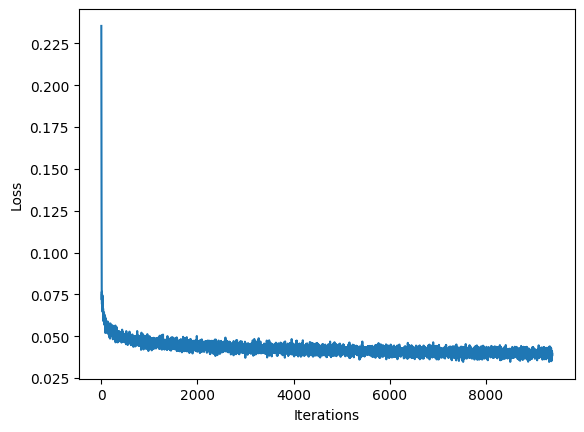

In [9]:
# Defining the Plot Style
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the losses
plt.plot(losses)

In [10]:
# Plot latent space
plot_latent(data_loader, autoencoder.encoder)
plt.savefig('latent.pdf')

In [11]:
# Generate samples from latent space
plot_reconstructed(autoencoder.decoder,w,h)
plt.savefig('reconstruction.pdf')

In [12]:
def plot_pca_latent(data_loader, pca, dim1=0, dim2=1, num_batches=100):
    for i, (x, y) in enumerate(data_loader):
        x_flat = x.view(x.size(0), -1).numpy()  # Flatten the images for PCA
        z = pca.transform(x_flat)  # Transform the flat images using PCA
        plt.scatter(z[:, dim1], z[:, dim2], c=y, alpha=0.5)
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()

In [13]:
def plot_pca_reconstructed(pca, w, h, r0=(-10, 10), r1=(-10, 10), n=12):
    img = np.zeros((n*w, n*h))
    mean = pca.mean_
    components = pca.components_
    explained_variance = pca.explained_variance_

    for i, yi in enumerate(np.linspace(*r1, n)):
        for j, xi in enumerate(np.linspace(*r0, n)):
            z = np.array([xi, yi])
            x_hat = mean + np.dot(z * np.sqrt(explained_variance), components)
            x_hat = x_hat.reshape(w, h)
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat

    plt.imshow(img, extent=[*r0, *r1])

In [14]:
from sklearn.decomposition import PCA
# Transform and DataLoader setup
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))
])

data = datasets.MNIST('./data', transform=transform, download=True)
n, w, h = data.data.shape
data_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)

# Fit PCA
x_example, _ = next(iter(data_loader))
x_flat = x_example.view(x_example.size(0), -1)
pca = PCA(n_components=2)
pca.fit(x_flat)

PCA(n_components=2)

In [15]:
# Plot latent space
plot_pca_latent(data_loader, pca)
plt.savefig('pca_latent.pdf')

<Figure size 640x480 with 0 Axes>

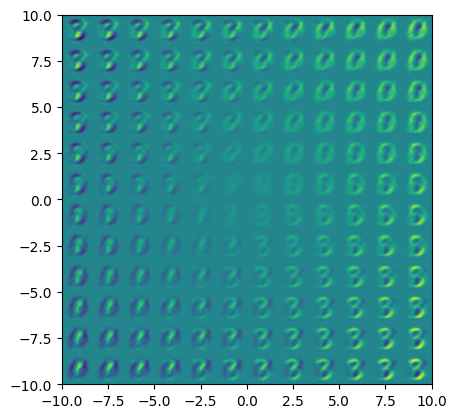

In [16]:
# Generate samples from latent space
plot_pca_reconstructed(pca, w, h)
plt.savefig('pca_reconstruction.pdf')

In [17]:
# Plot reconstruction error versus number of latent nodes
import torch.optim as optim

def compute_error(model, data_loader):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# Experiment with different dimensions
dimensions = range(2, 21)
autoencoder_errors = []
pca_errors = []

for dim in dimensions:
    # Autoencoder setup and training
    autoencoder = Autoencoder(784, 512, dim)
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    loss_function = nn.MSELoss()
    trained_autoencoder, _ = train(data_loader, autoencoder, optimizer, loss_function, epochs=20)

    # Autoencoder error evaluation
    ae_error = compute_error(trained_autoencoder, data_loader)
    autoencoder_errors.append(ae_error)

    # PCA setup and error calculation
    pca = PCA(n_components=dim)
    x_flat = np.vstack([x.view(x.size(0), -1).numpy() for x, _ in data_loader])
    pca.fit(x_flat)
    x_pca = pca.transform(x_flat)
    x_reconstructed = pca.inverse_transform(x_pca)
    pca_error = np.mean(np.square(x_flat - x_reconstructed))
    pca_errors.append(pca_error)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(dimensions, autoencoder_errors, label='Autoencoder Reconstruction Error')
plt.plot(dimensions, pca_errors, label='PCA Reconstruction Error')
plt.xlabel('Number of Dimensions (dim3)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error as a Function of Number of Dimensions')
plt.legend()
plt.grid(True)
plt.show()

0/0: 0.23206070065498352
0/100: 0.05797523260116577
0/200: 0.050088346004486084
0/300: 0.0499589778482914
0/400: 0.048018649220466614
1/0: 0.049671877175569534
1/100: 0.04381739720702171
1/200: 0.0471540167927742
1/300: 0.045934826135635376
1/400: 0.04541062191128731
2/0: 0.045729029923677444
2/100: 0.04824430122971535
2/200: 0.044570885598659515
2/300: 0.04527087137103081
2/400: 0.04568136855959892
3/0: 0.046511854976415634
3/100: 0.04659895598888397
3/200: 0.04477860406041145
3/300: 0.04439336061477661
3/400: 0.045940760523080826
4/0: 0.045166004449129105
4/100: 0.04274773225188255
4/200: 0.046812504529953
4/300: 0.04305661469697952
4/400: 0.045227400958538055
0/0: 0.23300805687904358
0/100: 0.05582796782255173
0/200: 0.047136738896369934
0/300: 0.04294333606958389
0/400: 0.04197469353675842
1/0: 0.04076428338885307
1/100: 0.03988836333155632
1/200: 0.03825255483388901
1/300: 0.04019593074917793
1/400: 0.03928368538618088
2/0: 0.03928358852863312
2/100: 0.0390181727707386
2/200: 0.03